In [35]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 14 23:26:53 2022

@author: ethan
"""
import json
import math
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import itertools
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import numpy as np
from scipy import signal
import pickle
import gc


In [96]:
#%reset -f

In [2]:
# define functions to load in data
def loadJson(dir):
    data_path = dir + "\\examples.json"
    with open(data_path,"r") as fp:
        data_json = json.load(fp)
    return data_json

def get_spectrogram(waveform):
    frame_length = 512
    frame_step = 256
    mel_spectrogram = tfio.audio.melscale(tfio.audio.spectrogram(input=tf.cast(waveform, tf.float32), nfft=frame_length, window=frame_length, stride=frame_step), rate=16000, mels=128, fmin=0, fmax=8000)
    return mel_spectrogram

def loadDataset(datajson, path, ds_range):
    ds_size = ds_range[1]-ds_range[0]
    instrument_ids = np.zeros(ds_size)
    pitch_ids = np.zeros(ds_size)
    sxx_log = np.zeros((ds_size,250,128))
    idxrange = range(ds_range[0],ds_range[1])
    keylist = list(datajson.keys())
    for i,j in enumerate(idxrange):
        file = keylist[j]
        sxx_log[i][:][:] = tfio.audio.dbscale(tf.cast(get_spectrogram(wavfile.read(path + "\\audio\\" + file + ".wav")[1]),dtype=tf.float32), top_db=80)
        instrument_ids[i] = datajson[file]["instrument_family"]
        pitch_ids[i] = datajson[file]["pitch"]
    return sxx_log, instrument_ids, pitch_ids
    
def sortDataset(datajson):
    insts = range(0,11)
    keylist = list(datajson.keys())
    inst_list = ()
    for inst in insts:
        inst_list = inst_list + ({key:datajson[key] for key in keylist if datajson[key]["instrument_family"]==inst},)
    return inst_list

def createFolds(datajson,k):
    num_per_inst = [math.floor(len(set)/k) for set in datajson]
    folds = ()
    for fold in range(0,k):
        temp = {}
        for inst in range(0,11):
            keylist = list(datajson[inst].keys())
            for idx in range(num_per_inst[inst]*fold,num_per_inst[inst]*(fold+1)):
                temp.update({keylist[idx]:datajson[inst][keylist[idx]]})
        folds = folds + (temp,)
    return folds

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    #if normalize:
    cm_p = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}\n{:0.2%}".format(cm[i, j],cm_p[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
# Open json with all metadata
train_dir = os.getcwd() + "\\nsynth-train"
valid_dir = os.getcwd() + "\\nsynth-valid"
test_dir = os.getcwd() + "\\nsynth-test"

train_json = loadJson(train_dir)
valid_json = loadJson(valid_dir)
test_json = loadJson(test_dir)

# human readable labels for data    
instrument_names = ["bass","brass","flute","guitar","keyboard","mallet","organ","reed","string","synth_lead","vocal"]


In [4]:
# sort training set by instrument class
inst_lists = sortDataset(train_json)


In [5]:
# create our 10 folds of train and test data
k = 10

folds = createFolds(inst_lists,k)


In [6]:
# Parameters to load in datasets

ds_size_train = len(folds[0])
ds_range_train = [0,ds_size_train]
num_train_sets = k

ds_size_val = len(valid_json)
ds_range_val = [0,ds_size_val]
ds_size_test = len(test_json)
ds_range_test = [0,ds_size_test]


In [10]:
# Load in data from scratch
# Don't do this if everything is already saved

#valid_set, valid_inst_id, _ = loadDataset(valid_json,valid_dir,ds_range_val)
#test_set, test_inst_id, _ = loadDataset(test_json,test_dir,ds_range_test)


In [11]:
# save the spectrogram sets so we don't have to generate again if we want

#with open(valid_dir+"\\valid_set","wb") as fp:
#    pickle.dump((valid_set,valid_inst_id),fp)
#with open(test_dir+"\\test_set","wb") as fp:
#    pickle.dump((test_set,test_inst_id),fp)


In [8]:
# save training spectrograms for each of the k folds (this is a ton of data)

#for chunk in range(0,num_train_sets):
#    train_set, train_inst_id, _ = loadDataset(folds[chunk],train_dir,ds_range_train)
#    with open(train_dir+"\\train_fold"+str(chunk),"wb") as fp:
#        pickle.dump((train_set,train_inst_id),fp)

In [7]:
# Load data from pickle if we have it
valid_set, valid_inst_id= pickle.load(open(valid_dir+"\\valid_set","rb"))
test_set, test_inst_id = pickle.load(open(test_dir+"\\test_set","rb"))

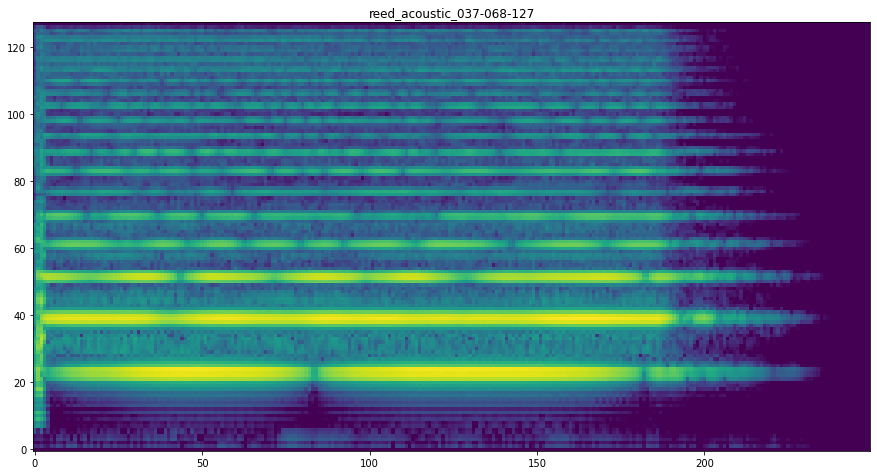

In [28]:
# look at a spectrogram
keylist = list(test_json.keys())
test_num = 3
plt.figure(figsize=(15, 12))
plt.imshow(test_set[test_num][:][:].T,origin='lower')
plt.title(str(keylist[test_num]))
plt.show()

In [23]:
# get some parameters for model
num_classes = len(instrument_names)
img_height = tf.shape(test_set)[1]
img_width = tf.shape(test_set)[2]
max_val = tf.math.reduce_max(test_set)


In [46]:
# make model
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./max_val, input_shape=(img_height, img_width,1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# can add fusion layer with tf.keras.layers.Concatenate -> 
# concatenate second-to-output layer from each model, then do hard decision dense layer
# change definition of model -> x = layer1(input), y1 = layer2a(x), y2 = layer2b(x), z = Concatenate()([y1,y2]), out = layer3(z)
# model = tf.keras.Model(inputs = input, outputs = out)

In [47]:
# set hyperparameters
learning_rate = 0.125

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)


In [32]:
# Gonna do each of my k folds individually i think
leave_out = 0
val_fold_set, val_fold_id = pickle.load(open(train_dir+"\\train_fold"+str(leave_out),"rb"))


Fitting:

Starting training data chunk 1/10

Starting training data chunk 2/10


KeyboardInterrupt: 

In [49]:
# Set the epochs
epochs = 5
print('\nFitting:')

# Train the model. Batch size of 32 by default

for chunk in range(0,num_train_sets):
    print('\nStarting training data chunk %d/%d' % (chunk+1,num_train_sets))
    if chunk != leave_out:
        train_set, train_inst_id = pickle.load(open(train_dir+"\\train_fold"+str(chunk),"rb"))
        
        #shuffle training data
        shuff_idx = np.random.permutation(len(train_inst_id))
        train_set = train_set[shuff_idx]
        train_inst_id = train_inst_id[shuff_idx]

        history = model.fit(train_set,train_inst_id, epochs=epochs,validation_data=(val_fold_set,val_fold_id))
        del train_set
        del train_inst_id
        gc.collect()
    
# Save weights from trained model

model.save_weights("fold_"+str(leave_out)+"_weights")   



Starting training data chunk 1/10

Starting training data chunk 2/10
Epoch 1/5
904/904 [==============================] - 477s 527ms/step - loss: 1.4563 - accuracy: 0.4773 - val_loss: 1.2882 - val_accuracy: 0.5541
Epoch 2/5
904/904 [==============================] - 368s 407ms/step - loss: 0.8766 - accuracy: 0.6937 - val_loss: 0.7755 - val_accuracy: 0.7250
Epoch 3/5
904/904 [==============================] - 364s 403ms/step - loss: 0.6296 - accuracy: 0.7796 - val_loss: 0.6832 - val_accuracy: 0.7711
Epoch 4/5
904/904 [==============================] - 365s 404ms/step - loss: 0.4504 - accuracy: 0.8446 - val_loss: 0.6238 - val_accuracy: 0.7867
Epoch 5/5
904/904 [==============================] - 357s 395ms/step - loss: 0.3393 - accuracy: 0.8832 - val_loss: 0.4117 - val_accuracy: 0.8651

Starting training data chunk 3/10
Epoch 1/5
904/904 [==============================] - 524s 580ms/step - loss: 0.4094 - accuracy: 0.8609 - val_loss: 0.4746 - val_accuracy: 0.8388
Epoch 2/5
904/904 [======

In [50]:
# validate that set with the fold we left out
validate = model.predict(val_fold_set)
validate_hard_decision = tf.math.argmax(validate,axis=1)
k_valid_conf_matrix = tf.math.confusion_matrix(val_fold_id, validate_hard_decision)
plot_confusion_matrix(k_valid_conf_matrix.numpy(),instrument_names,normalize=False)

In [52]:
# after the model is fully trained on all the folds, predict on the final test set
predicitons = model.predict(test_set)
predictions_hard_decision = tf.math.argmax(predicitons,axis=1)
conf_matrix = tf.math.confusion_matrix(test_inst_id, predictions_hard_decision)
plot_confusion_matrix(conf_matrix.numpy(),instrument_names,normalize=False)


In [24]:
# Load weights into new model
saved_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./max_val, input_shape=(img_height, img_width,1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
learning_rate = 0.125

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
saved_model.compile(optimizer, loss_fn, metrics)

saved_model.load_weights("fold_"+str(leave_out)+"_weights")


In [25]:
# Verify loaded model works
saved_predicitons = saved_model.predict(test_set)
saved_predictions_hard_decision = tf.math.argmax(saved_predicitons,axis=1)
saved_conf_matrix = tf.math.confusion_matrix(test_inst_id, saved_predictions_hard_decision)
plot_confusion_matrix(saved_conf_matrix.numpy(),instrument_names,normalize=False)

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[594,   0,  12,  88,  90,  40,   2,   0,   2,   9,   6],
       [  4, 164,  24,   7,  44,   0,   0,  16,  10,   0,   0],
       [  6,   4, 101,   0,  11,  16,   9,   9,   0,   0,  24],
       [139,   1,   0, 309, 183,  12,   3,   0,   4,   1,   0],
       [ 68,   5,   7,  83, 530,  36,   4,   1,  13,  19,   0],
       [ 17,   0,   1,  22,  42, 113,   0,   3,   3,   1,   0],
       [ 37,  18,   4,   0,  13,  12, 298,   2,   4,  19,  95],
       [ 28,  60,  11,  23,   3,   0,   0, 110,   0,   0,   0],
       [ 23,   0,   1,  10,   0,   1,   0,   0, 271,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 10,   0,   3,   8,   0,   4,   5,   2,   0,   2, 107]])>